In [1]:
import time
import numpy as np
import cvxpy as cp
import os.path as op

import importlib

from copy import deepcopy

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import h5py

import nibabel as nib

import sys
sys.path.append("../")

from src import nilearn_viz
from src import power_crtl
from src import pkl_custom
from src import plot_stat_on_surf

import networkx as nx

In [30]:
def standardize_array(arr):
    """
    Standardizes a numpy array to a range from 0 to 1.
    
    Parameters:
    arr (numpy.ndarray): Input array to be standardized.
    
    Returns:
    numpy.ndarray: Standardized array with values ranging from 0 to 1.
    """
    min_val = np.min(arr)
    max_val = np.max(arr)
    standardized_arr = (arr - min_val) / (max_val - min_val)
    return standardized_arr

from scipy.optimize import curve_fit

def exponential_decay(x, a, b, c):
    """
    Exponential decay function.
    
    Parameters:
    x (numpy.ndarray): Input array of x values.
    a (float): Initial value.
    b (float): Decay rate.
    c (float): Offset value.
    
    Returns:
    numpy.ndarray: Output array of y values.
    """
    return a * np.exp(-b * x) + c

def fit_exponential_decay(x, y):
    """
    Fits an exponential decay model to the given data.
    
    Parameters:
    x (numpy.ndarray): Array of x values.
    y (numpy.ndarray): Array of y values.
    
    Returns:
    tuple: Optimal values for the parameters and the covariance of the parameters.
    """
    # Initial guess for the parameters
    initial_guess = [max(y), 1.0, min(y)]
    
    # Fit the exponential decay model to the data
    params, covariance = curve_fit(exponential_decay, x, y, p0=initial_guess)
    
    return params, covariance


In [2]:
root_path = "../"
data_path = "/Users/mikichan/Desktop/mywork/atlas_data/"

In [7]:
scale = 1
connFilename = op.join(data_path, f'fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5')

hf = h5py.File(connFilename, 'r')
centers = np.array(hf.get('header').get('gmcoords'))
gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]
hf.close()

roi_path = op.join(data_path, 'fiber_atlas/gmlabels_vol.nii')
roi_atlas = nib.load(roi_path)

## Power Control - Testing behaviour and convergence

- Random initial state variation
- Noise level variation
- Weighting
- Correlation to degree
- Graph expansion by multi-step

In [52]:
adj = pkl_custom.open_pkl_file(op.join(root_path, './resources/lausanne2018-info.pkl'))['adjacency']
graph = nx.from_numpy_array(adj)
assert nx.is_connected(graph)

#### Quick sanity check of student's work

In [21]:
diff_prob = []
for k in tqdm(range(1000)):
    solver = power_crtl.PowerControl(deepcopy(adj), rand_p=True, seed_p=k)
    solver_updated = power_crtl.PowerControl_updated(deepcopy(adj), rand_p=True, 
                                                    seed_p=k, nodes_weight=np.ones(adj.shape[0]))

    tmp1 = solver.run()
    tmp2 = solver_updated.optimize()

    # np.testing.assert_almost_equal(tmp1, tmp2)
    diff_prob.append(np.abs(tmp1 - tmp2).sum())

100%|██████████| 1000/1000 [00:37<00:00, 26.36it/s]


In [23]:
# Both re-implentation and initial code are close enough
np.sum(diff_prob)

2.980651138222819

### Basic Results

In [27]:
solver_updated = power_crtl.PowerControl_updated(deepcopy(adj), rand_p=True, 
                                                seed_p=k, nodes_weight=np.ones(adj.shape[0]))

distrib, scores = solver_updated.optimize(logs=True)

Text(0, 0.5, 'Score')

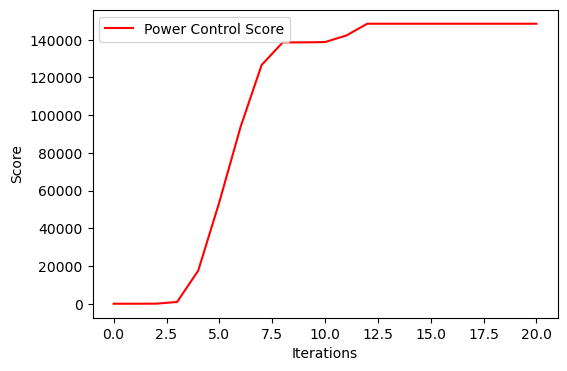

In [33]:
fig, ax = plt.subplots(1, figsize=(6, 4))
ax.plot(scores, label='Power Control Score', color='r')
ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Score')

### Random Initial State Variation

In [35]:
solutions = []
all_scores = []
for seed_k in tqdm(np.arange(1000)):
    solver = power_crtl.PowerControl(adj, rand_p=True, seed_p=seed_k)
    solver_updated = power_crtl.PowerControl_updated(deepcopy(adj), rand_p=True, 
                                                seed_p=seed_k, 
                                                nodes_weight=np.ones(adj.shape[0]))

    distrib, scores = solver_updated.optimize(logs=True)
    solutions.append(distrib)
    all_scores.append(scores)

solutions = np.array(solutions)

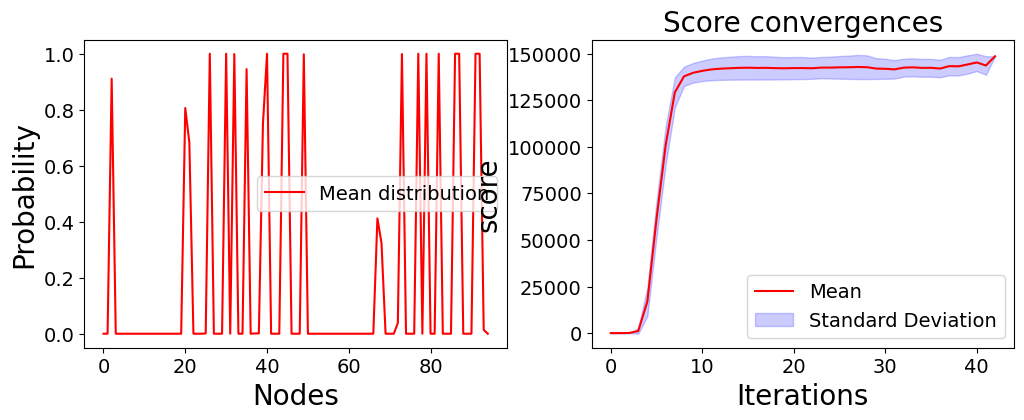

In [59]:
data = all_scores

# Find the maximum length of the lists
max_length = max(len(lst) for lst in data)

# Pad the lists with NaN to make them the same length
padded_data = [lst + [np.nan] * (max_length - len(lst)) for lst in data]

# Convert to a numpy array
padded_data = np.array(padded_data)

# Calculate the mean and standard deviation, ignoring NaNs
means = np.nanmean(padded_data, axis=0)
std_devs = np.nanstd(padded_data, axis=0)

# Create the x-axis values
x = np.arange(max_length)

# Plot the mean with standard deviation as fill_between error bar
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
mean_distribution = solutions.mean(axis=0)

ax[0].plot(mean_distribution, label='Mean distribution', color='r')
ax[0].legend(prop={'size': 14})
ax[0].set_xlabel('Nodes', fontsize=20)
ax[0].set_ylabel('Probability', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=10)

ax[1].plot(x, means, label='Mean', color='r')
ax[1].fill_between(x, means - std_devs, means + std_devs, color='b', alpha=0.2, label='Standard Deviation')
ax[1].set_xlabel('Iterations', fontsize=20)
ax[1].set_ylabel('score', fontsize=20)
ax[1].set_title('Score convergences', fontsize=20)
# Increase the size of ticks
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=10)
ax[1].legend(prop={'size': 14})
plt.show()

### Noise Variations

In [66]:
noise_levels = np.logspace(-2, 4, 7)

noise_solutions = []
noise_all_scores = []
for level in noise_levels:
    solutions = []
    all_scores = []
    for seed_k in tqdm(np.arange(1000)):
        solver = power_crtl.PowerControl(adj, rand_p=True, seed_p=seed_k)
        solver_updated = power_crtl.PowerControl_updated(deepcopy(adj), rand_p=True, 
                                                    seed_p=seed_k, 
                                                    nodes_weight=np.ones(adj.shape[0]), sig_init=level)

        distrib, scores = solver_updated.optimize(logs=True)
        solutions.append(distrib)
        all_scores.append(scores)

    solutions = np.array(solutions)
    noise_solutions.append(solutions)
    noise_all_scores.append(all_scores)


100%|██████████| 1000/1000 [00:01<00:00, 538.48it/s]


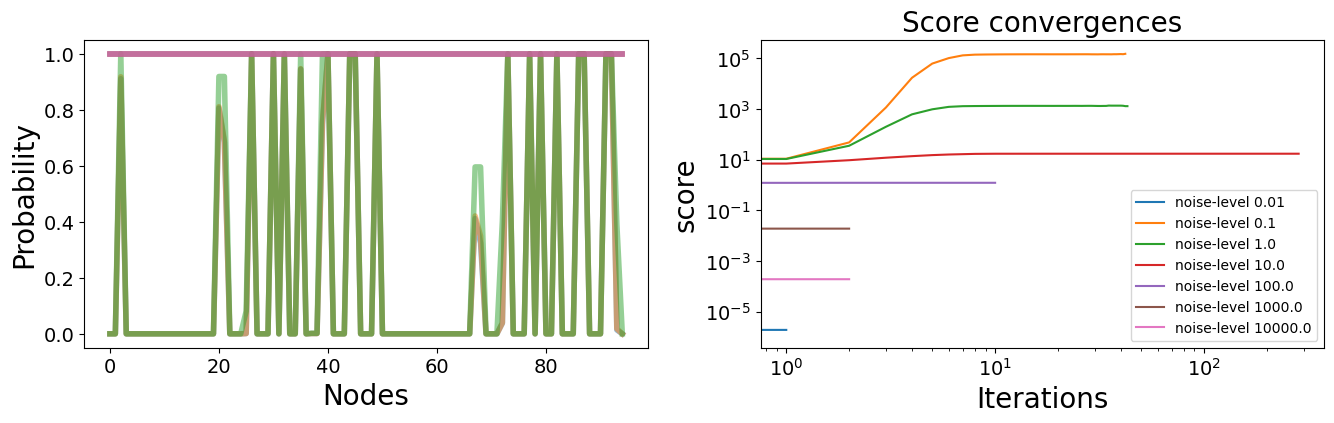

In [79]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

for lidx, level in enumerate(noise_levels):
    mean_distribution = noise_solutions[lidx].mean(axis=0)

    ax[0].plot(mean_distribution, label='Mean distribution', color=colors[lidx], alpha=0.5, linewidth=4)
    # ax[0].legend(prop={'size': 14})
    ax[0].set_xlabel('Nodes', fontsize=20)
    ax[0].set_ylabel('Probability', fontsize=20)
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[0].tick_params(axis='both', which='minor', labelsize=10)

    data = noise_all_scores[lidx]

    max_length = max(len(lst) for lst in data)
    padded_data = [lst + [np.nan] * (max_length - len(lst)) for lst in data]
    padded_data = np.array(padded_data)
    means = np.nanmean(padded_data, axis=0)
    std_devs = np.nanstd(padded_data, axis=0)
    x = np.arange(max_length)

    ax[1].plot(x, means, label=f'noise-level {level}', color=colors[lidx])
    # ax[1].fill_between(x, means - std_devs, means + std_devs, color=colors[lidx],
    #                     alpha=0.2)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')

    ax[1].set_xlabel('Iterations', fontsize=20)
    ax[1].set_ylabel('score', fontsize=20)
    ax[1].set_title('Score convergences', fontsize=20)

    # Increase the size of ticks
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[1].tick_params(axis='both', which='minor', labelsize=10)
    ax[1].legend(prop={'size': 10})
plt.show()

### Weightings

In [88]:
fix_node = 0
weight_levels = np.logspace(-2, 4, 7)

weight_solutions = []
weight_all_scores = []
for level in weight_levels:
    nodes_weight = np.ones(adj.shape[0])
    nodes_weight[fix_node] = level

    solutions = []
    all_scores = []
    for seed_k in tqdm(np.arange(1000)):
        solver = power_crtl.PowerControl(adj, rand_p=True, seed_p=seed_k)
        solver_updated = power_crtl.PowerControl_updated(deepcopy(adj), rand_p=True, 
                                                    seed_p=seed_k, 
                                                    nodes_weight=nodes_weight)

        distrib, scores = solver_updated.optimize(logs=True)
        solutions.append(distrib)
        all_scores.append(scores)

    solutions = np.array(solutions)
    weight_solutions.append(solutions)
    weight_all_scores.append(all_scores)


100%|██████████| 1000/1000 [00:18<00:00, 55.12it/s]


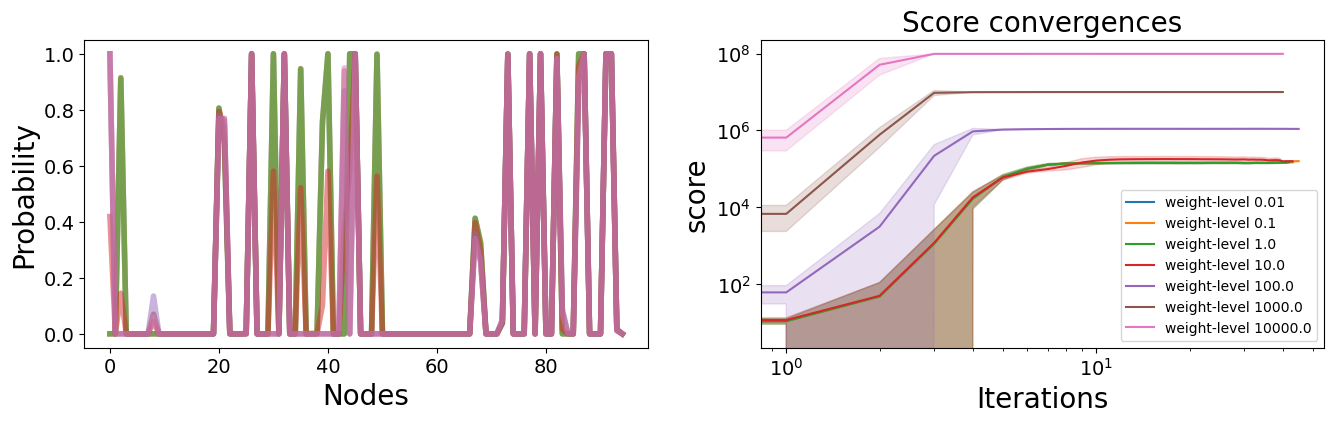

In [90]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

for lidx, level in enumerate(weight_levels):
    mean_distribution = weight_solutions[lidx].mean(axis=0)

    ax[0].plot(mean_distribution, label='Mean distribution', color=colors[lidx], alpha=0.5, linewidth=4)
    # ax[0].legend(prop={'size': 14})
    ax[0].set_xlabel('Nodes', fontsize=20)
    ax[0].set_ylabel('Probability', fontsize=20)
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[0].tick_params(axis='both', which='minor', labelsize=10)

    data = weight_all_scores[lidx]

    max_length = max(len(lst) for lst in data)
    padded_data = [lst + [np.nan] * (max_length - len(lst)) for lst in data]
    padded_data = np.array(padded_data)
    means = np.nanmean(padded_data, axis=0)
    std_devs = np.nanstd(padded_data, axis=0)
    x = np.arange(max_length)

    ax[1].plot(x, means, label=f'weight-level {level}', color=colors[lidx])
    ax[1].fill_between(x, means - std_devs, means + std_devs, color=colors[lidx],
                        alpha=0.2)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')

    ax[1].set_xlabel('Iterations', fontsize=20)
    ax[1].set_ylabel('score', fontsize=20)
    ax[1].set_title('Score convergences', fontsize=20)

    # Increase the size of ticks
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[1].tick_params(axis='both', which='minor', labelsize=10)
    ax[1].legend(prop={'size': 10})
plt.show()

### Correlation to degree

In [9]:
solutions = []
all_scores = []
for seed_k in tqdm(np.arange(1000)):
    solver_updated = power_crtl.PowerControl_updated(deepcopy(adj), rand_p=True, 
                                                seed_p=seed_k, 
                                                nodes_weight=np.ones(adj.shape[0]))

    distrib, scores = solver_updated.optimize(logs=True)
    solutions.append(distrib)
    all_scores.append(scores)

solutions = np.array(solutions)

100%|██████████| 1000/1000 [00:18<00:00, 54.25it/s]


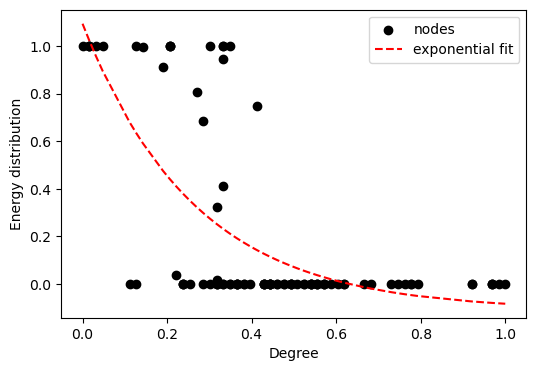

In [28]:
degree = standardize_array(adj.sum(axis=0))
distrib = standardize_array(solutions.mean(axis=0))
params, covariance = fit_exponential_decay(degree, distrib)

fig, ax = plt.subplots(1, figsize=(6, 4))
ax.scatter(degree, distrib, label='nodes', color='k')
ax.plot(np.sort(degree), exponential_decay(np.sort(degree), *params), color="red", linestyle='--', label='exponential fit')
ax.set_xlabel('Degree')
ax.set_ylabel('Energy distribution')
ax.legend()

### Graph expansion by multi-step

In [60]:
def k_hop_adjacency(adj, k):
    """
    Computes a new adjacency matrix where each row indicates nodes that are exactly k hops away.

    Parameters:
    adj (numpy.ndarray): Input adjacency matrix.
    k (int): Number of hops.

    Returns:
    numpy.ndarray: New adjacency matrix with k-hop connections.
    """
    # Initialize the k-hop adjacency matrix with zeros
    k_hop_adj = np.zeros_like(adj)

    # Compute the k-th power of the adjacency matrix
    adj_k = np.linalg.matrix_power(adj, k)

    # Iterate through each node
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            # Set to 1 if there is a path of exactly k hops
            if adj_k[i, j] > 0 and adj[i, j] == 0:
                k_hop_adj[i, j] = 1

    return k_hop_adj

# Example usage
k = 2
expand_adj = k_hop_adjacency(adj, k)
expand_adj = expand_adj - np.eye(nb_regions)
expand_adj *= 0.5
expand_adj = adj + expand_adj

In [61]:
solutions = []
all_scores = []
for seed_k in tqdm(np.arange(1000)):
    solver_updated = power_crtl.PowerControl_updated(deepcopy(expand_adj), rand_p=True, 
                                                seed_p=seed_k, 
                                                nodes_weight=np.ones(adj.shape[0]))

    distrib, scores = solver_updated.optimize(logs=True)
    solutions.append(distrib)
    all_scores.append(scores)

solutions = np.array(solutions)

100%|██████████| 1000/1000 [00:39<00:00, 25.35it/s]


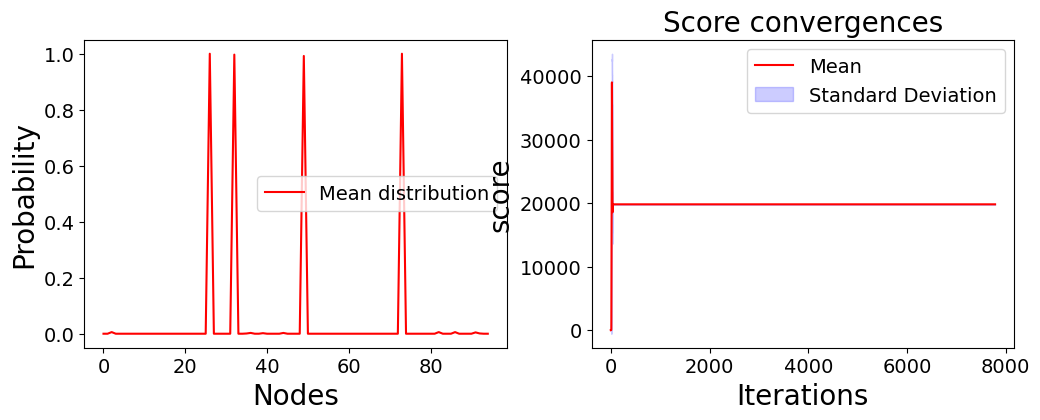

In [62]:
data = all_scores

max_length = max(len(lst) for lst in data)
padded_data = [lst + [np.nan] * (max_length - len(lst)) for lst in data]
padded_data = np.array(padded_data)
means = np.nanmean(padded_data, axis=0)
std_devs = np.nanstd(padded_data, axis=0)
x = np.arange(max_length)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
mean_distribution = solutions.mean(axis=0)

ax[0].plot(mean_distribution, label='Mean distribution', color='r')
ax[0].legend(prop={'size': 14})
ax[0].set_xlabel('Nodes', fontsize=20)
ax[0].set_ylabel('Probability', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=10)

ax[1].plot(x, means, label='Mean', color='r')
ax[1].fill_between(x, means - std_devs, means + std_devs, color='b', alpha=0.2, label='Standard Deviation')
ax[1].set_xlabel('Iterations', fontsize=20)
ax[1].set_ylabel('score', fontsize=20)
ax[1].set_title('Score convergences', fontsize=20)
# Increase the size of ticks
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=10)
ax[1].legend(prop={'size': 14})
plt.show()